---
# Classificador de Estrelas via SVMs

Introdução

# Preparação dos Dados

Importar dados


In [21]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/UERJ/Iniciação Científica/hygdata_v3.csv', dtype={'spect':'string'}) #especifica o tipo de spect (default 'object')
stars_raw = pd.DataFrame(data, columns= ['absmag', 'ci','spect'])

print(stars_raw.shape)

print(stars_raw.dtypes)

(119614, 3)
absmag    float64
ci        float64
spect      string
dtype: object


Passo 2: Filtrar linhas com dados omitidos

In [22]:
stars_raw.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True) # Filtrando colunas com valores omitidos
stars_raw.reset_index(drop=True, inplace=True) # Talvez possa colocar na linha de cima

print(stars_raw.shape)

print(stars_raw.dtypes)

display(stars_raw)

(115365, 3)
absmag    float64
ci        float64
spect      string
dtype: object


,absmag,ci,spect
0,4.850,0.656,G2V
1,2.390,0.482,F5
2,5.866,0.999,K3V
3,-1.619,-0.019,B9
4,2.421,0.370,F0V
...,...,...,...
115360,11.177,1.500,M3:
115361,11.010,1.540,k-m
115362,14.984,1.870,m
115363,11.482,1.640,M7


Passo 3: Tirar caracteres inválidos (strip) e aplicar o classificador às classes espectrais (translate)

OBS: strip e translate podem ser feitos dentro de uma única função

OBS2: Talvez seja possível juntar as linhas 3 e 4 em uma só, mas pode ser mais no translate (talvez seja resolvido com a OBS 1)

In [23]:
# Strip

def spect_refiner(obj_spect):
    readable_spect = ''
    for character in obj_spect:
        if character in valid_chars:
            readable_spect += character
    return readable_spect

valid_chars = ['I', 'V', 'a', 'b', 'D', '/', '-', 's', 'd']


stripped_data_spect = [spect_refiner(item) for item in stars_raw['spect'].tolist()]

stars_raw['stripped_spect'] = stripped_data_spect

#print('\n stripped DF')
display(stars_raw)

#stars_raw.to_csv('hyg_strip.csv') 

,absmag,ci,spect,stripped_spect
0,4.850,0.656,G2V,V
1,2.390,0.482,F5,
2,5.866,0.999,K3V,V
3,-1.619,-0.019,B9,
4,2.421,0.370,F0V,V
...,...,...,...,...
115360,11.177,1.500,M3:,
115361,11.010,1.540,k-m,-
115362,14.984,1.870,m,
115363,11.482,1.640,M7,


In [24]:
#translate

dict_estrelas = {'I':'Hiper/super gigante',
                 'Ia':'Super gigante luminosa',
                 'Iab':'Super gigante luminosa',
                 'Ib':'Super gigante menos luminosa',
                 'II':'Gigante luminosa', 
                 'III':'Gigantes', 
                 'IV':'Sub-gigantes', 
                 'V':'Sequência principal', 
                 'sd':'Sub-anãs', 
                 'D':'Anãs Brancas'
                }

def MK_translator(readable_spect):
    try:
        return dict_estrelas[readable_spect]
    except KeyError:
        #return 'string inválida'
        return ''

MK_class = [MK_translator(item) for item in stripped_data_spect]

stars_raw['MK class'] = MK_class

display(stars_raw)
#stars_raw.to_csv('hyg_translate.csv') 

,absmag,ci,spect,stripped_spect,MK class
0,4.850,0.656,G2V,V,Sequência principal
1,2.390,0.482,F5,,
2,5.866,0.999,K3V,V,Sequência principal
3,-1.619,-0.019,B9,,
4,2.421,0.370,F0V,V,Sequência principal
...,...,...,...,...,...
115360,11.177,1.500,M3:,,
115361,11.010,1.540,k-m,-,
115362,14.984,1.870,m,,
115363,11.482,1.640,M7,,


# Separação dos Dados

## Conjunto Principal
Novo filtro de dados 'omitidos' (não classificaveis)
Desta vez o filtro é baseado em uma string vazia na coluna 'MK class' em vez de um "buraco" no dataframe.

In [25]:
stars_main = stars_raw[stars_raw['MK class'] != '']  

print(stars_main.shape)

print(stars_main.dtypes)

display(stars_main)

(44267, 5)
absmag            float64
ci                float64
spect              string
stripped_spect     object
MK class           object
dtype: object


,absmag,ci,spect,stripped_spect,MK class
0,4.850,0.656,G2V,V,Sequência principal
2,5.866,0.999,K3V,V,Sequência principal
4,2.421,0.370,F0V,V,Sequência principal
5,1.494,0.902,G8III,III,Gigantes
6,8.607,1.336,M0V:,V,Sequência principal
...,...,...,...,...,...
115345,11.606,0.130,DA,D,Anãs Brancas
115350,12.257,0.180,DA,D,Anãs Brancas
115355,11.795,0.150,DA4,D,Anãs Brancas
115358,14.080,0.580,DA9,D,Anãs Brancas


## Conjunto de Não classificáveis
dataframe de dados rejeitados para analisar formato
OBS: alguns dados classificaveis com duas classes (ex: G8/K0III/IV) estão sendo ignorados. Separados por '/' ou '-'.

Algumas das estrelas apresentam duas ou mais classes de luminosidades dentro da classificação espectral. 

Quando separadas por '/', a estrela é de uma classe OU a outra

Quando separadas por '-', a estrela está entre as duas classes

In [26]:
stars_rejects = stars_raw[stars_raw['MK class'] == '']  

print(stars_rejects.shape)

print(stars_rejects.dtypes)

display(stars_rejects)

#stars_rejects.to_csv('hyg_rejects.csv') 

(71098, 5)
absmag            float64
ci                float64
spect              string
stripped_spect     object
MK class           object
dtype: object


,absmag,ci,spect,stripped_spect,MK class
1,2.390,0.482,F5,,
3,-1.619,-0.019,B9,,
7,5.828,0.740,G0,,
8,2.536,1.102,M6e-M8.5e Tc,-,
9,0.473,1.067,G5,,
...,...,...,...,...,...
115359,10.932,1.450,M1,,
115360,11.177,1.500,M3:,,
115361,11.010,1.540,k-m,-,
115362,14.984,1.870,m,,


### Repescagem

Dentro dos não classificáveis é criado um novo Dataframe com todos as Não classificáveis não nulos (nulos incluem os casos onde stripped_spect é '-'):

In [27]:
stars_valid_rejects_partial = stars_rejects[stars_raw['stripped_spect'] != '-'] # filtra valores onde o resultado é só '-'
stars_valid_rejects = stars_valid_rejects_partial[stars_raw['stripped_spect'] != ''] # filtra valores onde o resultado é ''

print(stars_valid_rejects.shape)

print(stars_valid_rejects.dtypes)

display(stars_valid_rejects)

stars_valid_rejects.to_csv('hyg_valid_rejects.csv') 

(12367, 5)
absmag            float64
ci                float64
spect              string
stripped_spect     object
MK class           object
dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,absmag,ci,spect,stripped_spect,MK class
21,1.175,0.962,G8/K0III/IV,/III/IV,
27,2.346,0.468,F3/F5V,/V,
33,2.066,0.514,F7.5IV-V,IV-V,
34,3.258,0.916,G8/K0III/IV,/III/IV,
42,0.508,1.032,G9III-IV,III-IV,
...,...,...,...,...,...
115313,11.767,1.600,dM4 e,d,
115337,10.981,1.550,dM4,d,
115340,12.348,0.160,DAV4,DV,
115343,13.421,1.650,dM6 e,d,


É criada uma nova função para separar as classes por '/'. É usado uma função de escolha aleatória para decidir entre as classes apresentadas, por isso o seed.

In [28]:
import numpy as np

def luminosity_separator(my_string, delimiter): 
    # Separa um espectro em classes de luminosidade separadas por delimiter e
    # filtra os casos em que não há nada antes da barra (caso " '' ")
    # OBS: my_string deve ter o espectro já refinado, ou podem aparecer "classes de luminosidade" que não fazem sentido
    #print(my_string)
    classes = my_string.split(delimiter)
    #print(classes)
    while '' in classes: classes.remove('') 
    #print(classes)
    try: # É necessário usar try e except porque em alguns casos a lista classes não tem itens, o que causa o ValueError
        return np.random.choice(classes)
    except ValueError:
        return ''

np.random.seed(0)

reject_stripped_spect = [luminosity_separator(item, '/') for item in stars_valid_rejects['stripped_spect'].tolist()]

stars_valid_rejects['stripped_spect'] = reject_stripped_spect

display(stars_valid_rejects)
stars_valid_rejects.to_csv('hyg_new_valid_rejects.csv') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,absmag,ci,spect,stripped_spect,MK class
21,1.175,0.962,G8/K0III/IV,III,
27,2.346,0.468,F3/F5V,V,
33,2.066,0.514,F7.5IV-V,IV-V,
34,3.258,0.916,G8/K0III/IV,IV,
42,0.508,1.032,G9III-IV,III-IV,
...,...,...,...,...,...
115313,11.767,1.600,dM4 e,d,
115337,10.981,1.550,dM4,d,
115340,12.348,0.160,DAV4,DV,
115343,13.421,1.650,dM6 e,d,


## Filtro para Anãs-Brancas

Filtrando valores que estão numa região inesperada do mapa absmag > 10

,absmag,ci,spect,stripped_spect,MK class
3708,14.222,0.554,DG,D,Anãs Brancas
5182,-7.770,-0.230,DA:,D,Anãs Brancas
9927,5.257,0.673,DF,D,Anãs Brancas
11252,1.487,0.294,DAn...,D,Anãs Brancas
11259,10.661,-0.056,DA,D,Anãs Brancas
...,...,...,...,...,...
115345,11.606,0.130,DA,D,Anãs Brancas
115350,12.257,0.180,DA,D,Anãs Brancas
115355,11.795,0.150,DA4,D,Anãs Brancas
115358,14.080,0.580,DA9,D,Anãs Brancas


(-0.5, 2.5)

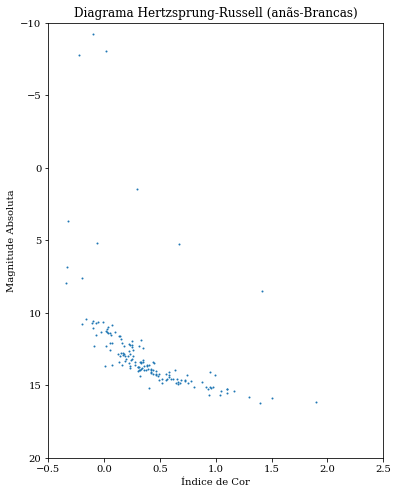

In [29]:
stars_wd = stars_main[(stars_main['stripped_spect'] == 'D')]
display(stars_wd)

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.default'] = 'regular'

fig = plt.figure(figsize = (6, 8))
ax = fig.add_subplot(1, 1, 1)


plt.scatter(stars_wd['ci'], stars_wd['absmag'], s = 1)
ax.set_title('Diagrama Hertzsprung-Russell (anãs-Brancas)')
ax.set_ylabel('Magnitude Absoluta')
ax.set_xlabel('Índice de Cor')
ax.set_ylim(20, -10)
ax.set_xlim(-0.5, 2.5)
#plt.colorbar(ax=ax, orientation='horizontal', fraction=.1)

#plt.scatter(stars_wd['ci'], stars_wd['absmag'])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(-0.5, 2.5)

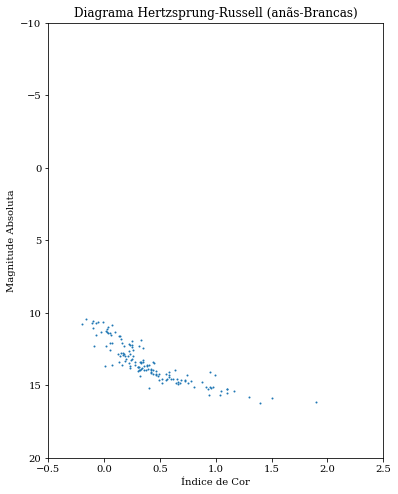

In [30]:
temp_wd_indexNames = stars_wd[ (stars_wd['absmag'] <= 10)
                                   & (stars_wd['stripped_spect'] == 'D') ].index
stars_wd.drop(temp_wd_indexNames , inplace=True)

fig = plt.figure(figsize = (6, 8))
ax = fig.add_subplot(1, 1, 1)


plt.scatter(stars_wd['ci'], stars_wd['absmag'], s = 1)
ax.set_title('Diagrama Hertzsprung-Russell (anãs-Brancas)')
ax.set_ylabel('Magnitude Absoluta')
ax.set_xlabel('Índice de Cor')
ax.set_ylim(20, -10)
ax.set_xlim(-0.5, 2.5)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(-0.5, 2.5)

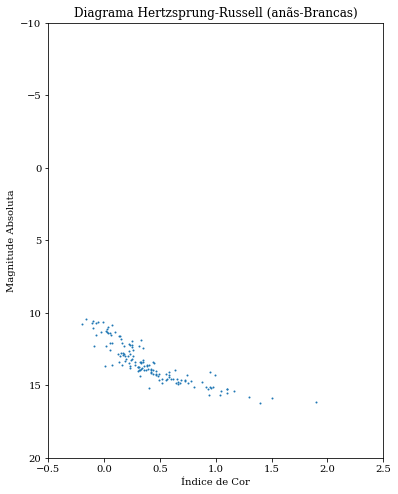

In [31]:
# Aplicando ao dataframe principal
wd_index = stars_main[ (stars_main['absmag'] <= 10)
                                   & (stars_main['stripped_spect'] == 'D') ].index
stars_main.drop(wd_index , inplace=True)

# plotando as anãs brancas no principal pós filtro
stars_wd_filtered = stars_main[(stars_main['stripped_spect'] == 'D')]
#display(stars_wd_filtered)

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.default'] = 'regular'

fig = plt.figure(figsize = (6, 8))
ax = fig.add_subplot(1, 1, 1)


plt.scatter(stars_wd_filtered['ci'], stars_wd_filtered['absmag'], s = 1)
ax.set_title('Diagrama Hertzsprung-Russell (anãs-Brancas)')
ax.set_ylabel('Magnitude Absoluta')
ax.set_xlabel('Índice de Cor')
ax.set_ylim(20, -10)
ax.set_xlim(-0.5, 2.5)

## Devolvendo ao conjunto principal

Para devolver ao conjunto principal, aplicamos novamente o tradutor à nova classe de luminosidade.

In [32]:
new_MK_class = [MK_translator(item) for item in stars_valid_rejects['stripped_spect'].tolist()]

stars_valid_rejects['MK class'] = new_MK_class

display(stars_valid_rejects)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,absmag,ci,spect,stripped_spect,MK class
21,1.175,0.962,G8/K0III/IV,III,Gigantes
27,2.346,0.468,F3/F5V,V,Sequência principal
33,2.066,0.514,F7.5IV-V,IV-V,
34,3.258,0.916,G8/K0III/IV,IV,Sub-gigantes
42,0.508,1.032,G9III-IV,III-IV,
...,...,...,...,...,...
115313,11.767,1.600,dM4 e,d,
115337,10.981,1.550,dM4,d,
115340,12.348,0.160,DAV4,DV,
115343,13.421,1.650,dM6 e,d,


Algumas estrelas ainda não puderam ser classificadas. Deve-se filtrar o dataframe novamente.

In [33]:
stars_saved_rejects = stars_valid_rejects[stars_valid_rejects['MK class'] != '']  

#print(stars_main.shape)

#print(stars_main.dtypes)

display(stars_saved_rejects)



,absmag,ci,spect,stripped_spect,MK class
21,1.175,0.962,G8/K0III/IV,III,Gigantes
27,2.346,0.468,F3/F5V,V,Sequência principal
34,3.258,0.916,G8/K0III/IV,IV,Sub-gigantes
46,-1.824,1.164,K0/K1III,III,Gigantes
52,3.338,0.551,G2IV/V,V,Sequência principal
...,...,...,...,...,...
114416,5.174,0.585,G3/G5V,V,Sequência principal
114417,3.580,0.578,G0III/IV,III,Gigantes
114449,2.459,0.211,A4:IV/Vn...,IV,Sub-gigantes
114927,13.565,0.400,DA/F,D,Anãs Brancas


In [34]:
#NOVOS REJEITADOS
stars_new_rejects_partial = stars_valid_rejects[stars_valid_rejects['MK class'] == '']
stars_new_rejects = stars_new_rejects_partial[stars_new_rejects_partial['stripped_spect'] != '']

display(stars_new_rejects)

stars_new_rejects.to_csv('hyg_new_rejects.csv') 

,absmag,ci,spect,stripped_spect,MK class
33,2.066,0.514,F7.5IV-V,IV-V,
42,0.508,1.032,G9III-IV,III-IV,
101,-0.281,0.970,G7II-III,II-III,
115,0.209,1.183,K1IIICNIV,IIIIV,
130,0.318,1.153,K2III-IV,III-IV,
...,...,...,...,...,...
115313,11.767,1.600,dM4 e,d,
115337,10.981,1.550,dM4,d,
115340,12.348,0.160,DAV4,DV,
115343,13.421,1.650,dM6 e,d,


In [35]:
stars_main = pd.concat([stars_main, stars_saved_rejects])

display(stars_main)



,absmag,ci,spect,stripped_spect,MK class
0,4.850,0.656,G2V,V,Sequência principal
2,5.866,0.999,K3V,V,Sequência principal
4,2.421,0.370,F0V,V,Sequência principal
5,1.494,0.902,G8III,III,Gigantes
6,8.607,1.336,M0V:,V,Sequência principal
...,...,...,...,...,...
114416,5.174,0.585,G3/G5V,V,Sequência principal
114417,3.580,0.578,G0III/IV,III,Gigantes
114449,2.459,0.211,A4:IV/Vn...,IV,Sub-gigantes
114927,13.565,0.400,DA/F,D,Anãs Brancas


Exportação do arquivo principal
OBS: Pesquisar como automatizar



In [36]:
frequency = stars_main['MK class'].value_counts()

print(frequency)

Sequência principal             25523
Gigantes                        20974
Sub-gigantes                     5802
Gigante luminosa                 1379
Super gigante menos luminosa      536
Super gigante luminosa            408
Anãs Brancas                      141
Sub-anãs                           74
Hiper/super gigante                13
Name: MK class, dtype: int64


In [37]:
stars_main.to_csv('/content/drive/MyDrive/hyg_main.csv') 

# Plot dos dados preparados

Plot por tipo de estrela

In [38]:
# Criando nova coluna relacionando a classe MK com um valor numérico

mk_index_dict = {'Hiper/super gigante' : 0,
                 'Gigante luminosa': 1, 
                 'Gigantes':2, 
                 'Sub-gigantes':3, 
                 'Sequência principal':4, 
                 'Sub-anãs':5, 
                 'Anãs Brancas':6,
                 'Super gigante luminosa':7,
                 'Super gigante luminosa':8,
                 'Super gigante menos luminosa':9
                 }

mk_index = [mk_index_dict[item] for item in stars_main['MK class'].tolist()]

stars_main['MK index'] = mk_index

display(stars_main)



,absmag,ci,spect,stripped_spect,MK class,MK index
0,4.850,0.656,G2V,V,Sequência principal,4
2,5.866,0.999,K3V,V,Sequência principal,4
4,2.421,0.370,F0V,V,Sequência principal,4
5,1.494,0.902,G8III,III,Gigantes,2
6,8.607,1.336,M0V:,V,Sequência principal,4
...,...,...,...,...,...,...
114416,5.174,0.585,G3/G5V,V,Sequência principal,4
114417,3.580,0.578,G0III/IV,III,Gigantes,2
114449,2.459,0.211,A4:IV/Vn...,IV,Sub-gigantes,3
114927,13.565,0.400,DA/F,D,Anãs Brancas,6


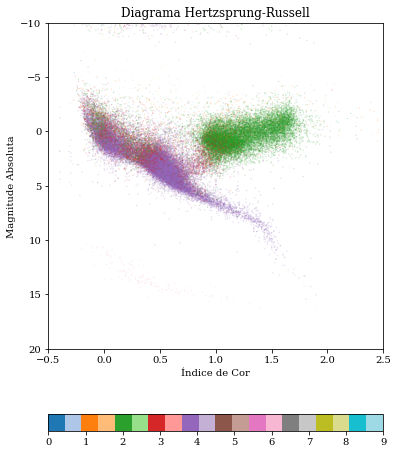

In [39]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.default'] = 'regular'

fig = plt.figure(figsize = (6, 8))
ax = fig.add_subplot(1, 1, 1)


plt.scatter(stars_main['ci'], stars_main['absmag'], s = 0.01, c = stars_main['MK index'], cmap='tab20')
ax.set_title('Diagrama Hertzsprung-Russell')
ax.set_ylabel('Magnitude Absoluta')
ax.set_xlabel('Índice de Cor')
ax.set_ylim(20, -10)
ax.set_xlim(-0.5, 2.5)
plt.colorbar(ax=ax, orientation='horizontal', fraction=.1)

Plot por temperatura

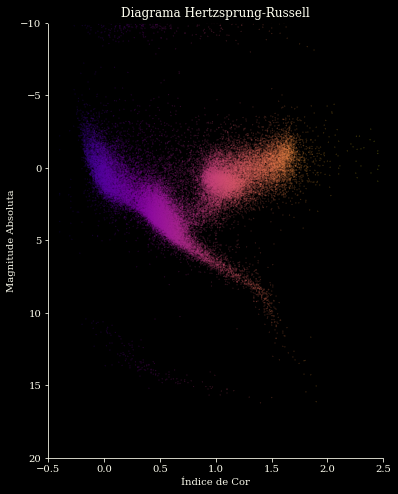

In [40]:
bgcolor = 'black'
wcolor = 'ivory'

fig = plt.figure(figsize = (6, 8), facecolor=bgcolor)
ax = fig.add_subplot(1, 1, 1)
plt.scatter(stars_main['ci'], stars_main['absmag'], s = 0.01, c = stars_main['ci'], cmap='plasma')
ax.set_title('Diagrama Hertzsprung-Russell')
ax.set_ylabel('Magnitude Absoluta')
ax.set_xlabel('Índice de Cor')
plt.clim(-0.5, 2.5)
ax.set_ylim(20, -10)
ax.set_xlim(-0.5, 2.5)
ax.set_facecolor(bgcolor)
ax.spines['bottom'].set_color(wcolor)
ax.spines['top'].set_color(bgcolor) 
ax.spines['right'].set_color(bgcolor)
ax.spines['left'].set_color(wcolor)

ax.title.set_color(wcolor)
ax.xaxis.label.set_color(wcolor)
ax.yaxis.label.set_color(wcolor)
ax.tick_params(colors=wcolor)
#plt.colorbar(ax=ax, orientation='horizontal', fraction=.1)